# 02 Results

Use this notebook to visualize final curves and compare experiments.

In [9]:
import os
%cd XAI/
print(os.getcwd())


c:\Users\titou\OneDrive\Bureau\mva\XAI
c:\Users\titou\OneDrive\Bureau\mva\XAI


c:\Users\titou\OneDrive\Bureau\mva\XAI\xaif


c:\Users\titou\miniforge3\envs\amande\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\titou\miniforge3\envs\amande\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


491
chainsaw


RISE: 100%|██████████| 2000/2000 [04:13<00:00,  7.89it/s]


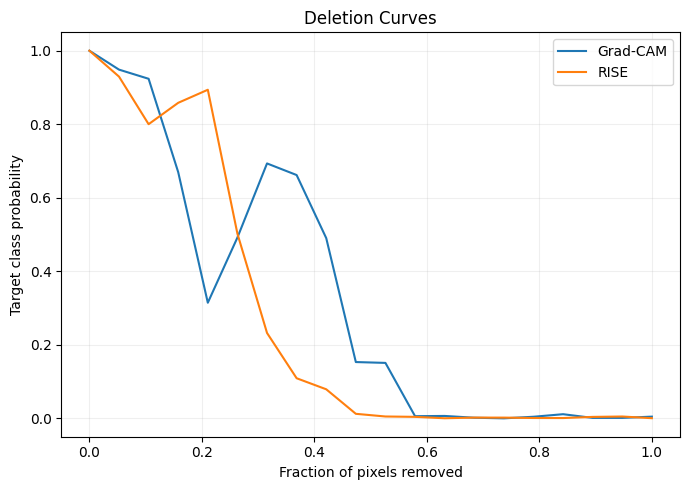

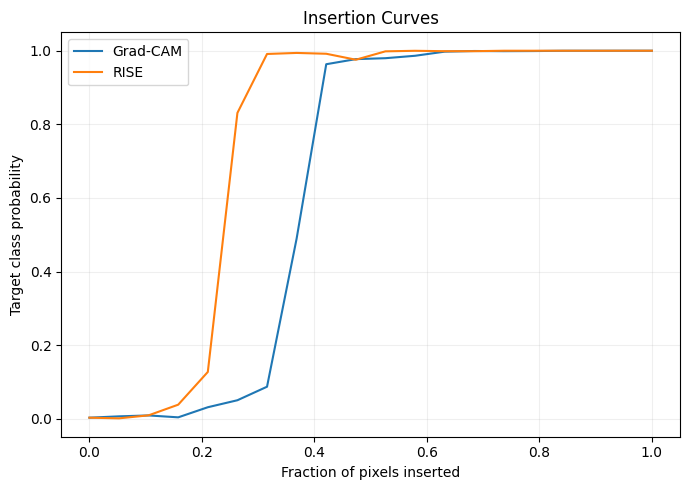

Deletion plot saved to: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chainsaw_1505\eval\deletion_curves.png
Insertion plot saved to: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chainsaw_1505\eval\insertion_curves.png
AUC deletion Grad-CAM: 0.3177
AUC deletion RISE: 0.2603
AUC insertion Grad-CAM: 0.6359
AUC insertion RISE: 0.7609


In [ ]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from torchvision.datasets import ImageFolder

from xaif.scripts.tools_for_data.data import image_to_tensor
from xaif.scripts.models.gradcam import compute_gradcam
from xaif.scripts.models.rise import compute_rise_saliency
from xaif.scripts.metrics.deletion import deletion_curve
from xaif.scripts.metrics.insertion import insertion_curve
from xaif.scripts.models.reset import get_resnet50, predict_class

%cd xaif/
# If notebook runs from xaif/notebooks, move to xaif root for clean relative paths
project_root = Path.cwd().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent

data_root = project_root / 'data' / 'imagenette2-320' / 'val'
labels_path = project_root / 'data' / 'imagenet_labels.json'

with open(labels_path, "r", encoding="utf-8") as f:
    imagenet_labels = json.load(f)



dataset = ImageFolder(str(data_root))
sample_index = 1505  # <-- change this index
steps = 20
num_masks = 2000
device = 'cpu'  # or 'cuda'

image_path, _ = dataset.samples[sample_index]
image_path = Path(image_path)




model = get_resnet50(device=device)
inp = image_to_tensor(image_path, image_size=224, device=device)
pred_class = predict_class(model, inp)
image_chw = inp[0].detach().cpu()


pred_class = predict_class(model, inp)
print(pred_class)
label = imagenet_labels[pred_class]
print(label)
safe_label = label.replace(" ", "_")

out_dir = project_root / 'outputs' / f'{safe_label}_{sample_index:04d}' / 'eval'
out_dir.mkdir(parents=True, exist_ok=True)

grad_map = compute_gradcam(model, inp, target_layers=[model.layer4[-1]], target_class=pred_class)
rise_map = compute_rise_saliency(model, inp, pred_class=pred_class, N=num_masks)

del_grad = deletion_curve(model, image_chw, grad_map, pred_class, steps=steps, device=device)
del_rise = deletion_curve(model, image_chw, rise_map, pred_class, steps=steps, device=device)
ins_grad = insertion_curve(model, image_chw, grad_map, pred_class, steps=steps, device=device)
ins_rise = insertion_curve(model, image_chw, rise_map, pred_class, steps=steps, device=device)

x = np.linspace(0, 1, steps)
auc_del_grad = auc(x, del_grad)
auc_del_rise = auc(x, del_rise)
auc_ins_grad = auc(x, ins_grad)
auc_ins_rise = auc(x, ins_rise)

x = np.linspace(0, 1, steps)

# -----------------------------
# Deletion curves
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(x, del_grad, label='Grad-CAM')
plt.plot(x, del_rise, label='RISE')
plt.xlabel('Fraction of pixels removed')
plt.ylabel('Target class probability')
plt.title('Deletion Curves')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
del_plot_path = out_dir / 'deletion_curves.png'
plt.savefig(del_plot_path, dpi=140)
plt.show()

# -----------------------------
# Insertion curves
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(x, ins_grad, label='Grad-CAM')
plt.plot(x, ins_rise, label='RISE')
plt.xlabel('Fraction of pixels inserted')
plt.ylabel('Target class probability')
plt.title('Insertion Curves')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
ins_plot_path = out_dir / 'insertion_curves.png'
plt.savefig(ins_plot_path, dpi=140)
plt.show()

print(f'Deletion plot saved to: {del_plot_path}')
print(f'Insertion plot saved to: {ins_plot_path}')
print(f'AUC deletion Grad-CAM: {auc_del_grad:.4f}')
print(f'AUC deletion RISE: {auc_del_rise:.4f}')
print(f'AUC insertion Grad-CAM: {auc_ins_grad:.4f}')
print(f'AUC insertion RISE: {auc_ins_rise:.4f}')

RISE: 100%|██████████| 2000/2000 [04:16<00:00,  7.81it/s]


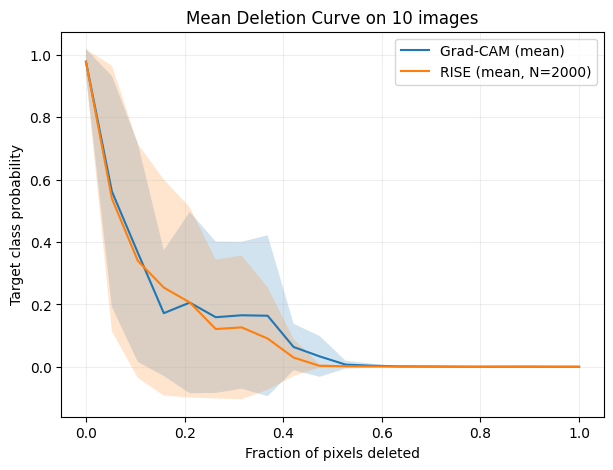

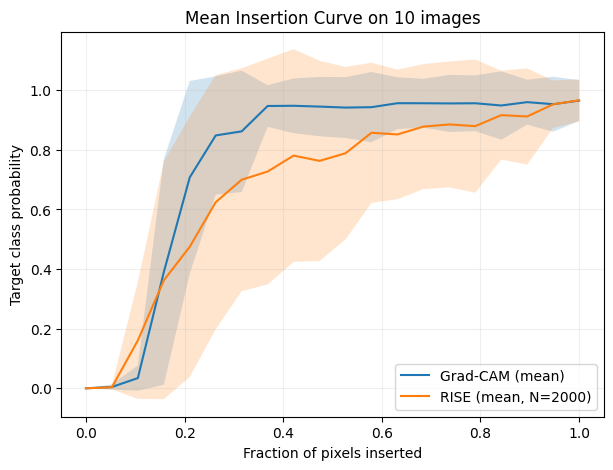

In [15]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder

 

# -----------------------------
# Parameters
# -----------------------------
num_images = 10       # nombre d'images à échantillonner
steps = 20              # steps pour deletion/insertion
num_masks = 2000         # pour RISE
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Dataset
# -----------------------------
data_root = "data/imagenette2-320/val"
labels_path = "data/imagenet_labels.json"
dataset = ImageFolder(data_root)
image_files = [p for p, _ in dataset.samples]

# Charger ImageNet labels
with open(labels_path, "r", encoding="utf-8") as f:
    imagenet_labels = json.load(f)

# -----------------------------
# Model
# -----------------------------
model = get_resnet50(device=device)
model.eval()

# Preprocess
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# -----------------------------
# Randomly sample images
# -----------------------------
rng = np.random.default_rng(42)
selected_indices = rng.choice(len(image_files), size=min(num_images, len(image_files)), replace=False)

selected_indices = rng.choice(100, size=min(num_images, len(image_files)), replace=False)
# -----------------------------
# Collect deletion & insertion curves
# -----------------------------
all_del_grad = []
all_del_rise = []
all_ins_grad = []
all_ins_rise = []

for idx in selected_indices:
    
    image_path, _ = dataset.samples[idx]
    image_path = Path(image_path)




    model = get_resnet50(device=device)
    inp = image_to_tensor(image_path, image_size=224, device=device)
    pred_class = predict_class(model, inp)
    image_chw = inp[0].detach().cpu()




    # Prediction
    with torch.no_grad():
        pred_class = model(inp).argmax(dim=1).item()

    # Grad-CAM
    grad_map = compute_gradcam(model, inp, target_layers=[model.layer4[-1]], target_class=pred_class)
    grad_map = (grad_map - grad_map.min()) / (grad_map.max() - grad_map.min() + 1e-8)

    # RISE
    rise_map = compute_rise_saliency(model, inp, pred_class=pred_class, N=num_masks)
    rise_map = (rise_map - rise_map.min()) / (rise_map.max() - rise_map.min() + 1e-8)

    # Deletion
    all_del_grad.append(deletion_curve(model, image_chw, grad_map, pred_class, steps=steps, device=device))
    all_del_rise.append(deletion_curve(model, image_chw, rise_map, pred_class, steps=steps, device=device))

    # Insertion
    all_ins_grad.append(insertion_curve(model, image_chw, grad_map, pred_class, steps=steps, device=device))
    all_ins_rise.append(insertion_curve(model, image_chw, rise_map, pred_class, steps=steps, device=device))

# -----------------------------
# Average curves
# -----------------------------
mean_del_grad = np.mean(all_del_grad, axis=0)
mean_del_rise = np.mean(all_del_rise, axis=0)
std_del_grad = np.std(all_del_grad, axis=0)
std_del_rise = np.std(all_del_rise, axis=0)

mean_ins_grad = np.mean(all_ins_grad, axis=0)
mean_ins_rise = np.mean(all_ins_rise, axis=0)
std_ins_grad = np.std(all_ins_grad, axis=0)
std_ins_rise = np.std(all_ins_rise, axis=0)

x = np.linspace(0, 1, steps)

# -----------------------------
# Plot deletion
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(x, mean_del_grad, label="Grad-CAM (mean)")
plt.fill_between(x, mean_del_grad - std_del_grad, mean_del_grad + std_del_grad, alpha=0.2)
plt.plot(x, mean_del_rise, label=f"RISE (mean, N={num_masks})")
plt.fill_between(x, mean_del_rise - std_del_rise, mean_del_rise + std_del_rise, alpha=0.2)
plt.xlabel("Fraction of pixels deleted")
plt.ylabel("Target class probability")
plt.title(f"Mean Deletion Curve on {len(selected_indices)} images")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# -----------------------------
# Plot insertion
# -----------------------------
plt.figure(figsize=(7, 5))
plt.plot(x, mean_ins_grad, label="Grad-CAM (mean)")
plt.fill_between(x, mean_ins_grad - std_ins_grad, mean_ins_grad + std_ins_grad, alpha=0.2)
plt.plot(x, mean_ins_rise, label=f"RISE (mean, N={num_masks})")
plt.fill_between(x, mean_ins_rise - std_ins_rise, mean_ins_rise + std_ins_rise, alpha=0.2)
plt.xlabel("Fraction of pixels inserted")
plt.ylabel("Target class probability")
plt.title(f"Mean Insertion Curve on {len(selected_indices)} images")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


In [ ]:
from xaif.scripts.tools_for_data.data import load_image
from xaif.scripts.tools_for_data.visualize import save_overlay_from_pil


# -------------------------------------------------
# Config
# -------------------------------------------------

device = "cpu"   # "cuda" si dispo
indices = list(range(0, 10))
# indices = random.sample(range(0, 5000), 20)  # random exemple

N_RISE = 2000
S_RISE = 8
P1_RISE = 0.5


# -------------------------------------------------
# Paths
# -------------------------------------------------

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data" / "imagenette2-320" / "val"
labels_path = project_root / "data" / "imagenet_labels.json"
outputs_root = project_root / "outputs" / "batch_xai"

outputs_root.mkdir(parents=True, exist_ok=True)


# -------------------------------------------------
# Dataset + labels
# -------------------------------------------------

dataset = ImageFolder(str(data_root))

with open(labels_path, "r", encoding="utf-8") as f:
    imagenet_labels = json.load(f)


# -------------------------------------------------
# Model
# -------------------------------------------------

model = get_resnet50(device=device)


# -------------------------------------------------
# Storage for mega-plot
# -------------------------------------------------

all_results = []


# -------------------------------------------------
# Loop
# -------------------------------------------------

for sample_index in indices:

    print(f"\nProcessing index {sample_index}")

    # -------------------------
    # Load image
    # -------------------------
    image_path, class_idx = dataset.samples[sample_index]
    image_path = Path(image_path)

    input_tensor = image_to_tensor(
        image_path,
        image_size=224,
        device=device
    )

    # -------------------------
    # Prediction
    # -------------------------
    pred_class = predict_class(model, input_tensor)
    label = imagenet_labels[pred_class]
    safe_label = label.replace(" ", "_")

    # -------------------------
    # Output dir
    # -------------------------
    out_dir = outputs_root / f"{safe_label}_{sample_index:04d}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # -------------------------
    # GradCAM
    # -------------------------
    cam = compute_gradcam(
        model,
        input_tensor,
        target_layers=[model.layer4[-1]],
        target_class=pred_class
    )

    # -------------------------
    # RISE
    # -------------------------
    rise_map = compute_rise_saliency(
        model=model,
        input_tensor=input_tensor,
        pred_class=pred_class,
        N=N_RISE,
        s=S_RISE,
        p1=P1_RISE
    )

    # -------------------------
    # Save images
    # -------------------------
    img = load_image(image_path)

    img.resize((224, 224)).save(out_dir / "input.jpg")

    save_overlay_from_pil(img, cam, out_dir / "gradcam_overlay.jpg")
    Image.fromarray((cam * 255).astype("uint8")).save(
        out_dir / "gradcam_map.jpg"
    )

    save_overlay_from_pil(img, rise_map, out_dir / "rise_overlay.jpg")
    Image.fromarray((rise_map * 255).astype("uint8")).save(
        out_dir / "rise_map.jpg"
    )

    # -------------------------
    # Store for plotting
    # -------------------------
    all_results.append({
        "input": out_dir / "input.jpg",
        "gradcam_overlay": out_dir / "gradcam_overlay.jpg",
        "gradcam_map": out_dir / "gradcam_map.jpg",
        "rise_overlay": out_dir / "rise_overlay.jpg",
        "rise_map": out_dir / "rise_map.jpg",
        "label": label,
        "index": sample_index
    })


# -------------------------------------------------
# Individual plots
# -------------------------------------------------

for res in all_results:

    fig, axes = plt.subplots(1, 5, figsize=(18, 4))

    axes[0].imshow(Image.open(res["input"]))
    axes[0].set_title("Input")
    axes[0].axis("off")

    axes[1].imshow(Image.open(res["gradcam_overlay"]))
    axes[1].set_title("GradCAM Overlay")
    axes[1].axis("off")

    axes[2].imshow(Image.open(res["gradcam_map"]), cmap="jet")
    axes[2].set_title("GradCAM Map")
    axes[2].axis("off")

    axes[3].imshow(Image.open(res["rise_overlay"]))
    axes[3].set_title("RISE Overlay")
    axes[3].axis("off")

    axes[4].imshow(Image.open(res["rise_map"]), cmap="jet")
    axes[4].set_title("RISE Map")
    axes[4].axis("off")

    plt.suptitle(
        f"{res['label']} (idx={res['index']})",
        fontsize=14
    )

    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# Mega grid (optional)
# -------------------------------------------------

n = len(all_results)
cols = 5
rows = n

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))

for i, res in enumerate(all_results):

    axes[i, 0].imshow(Image.open(res["input"]))
    axes[i, 0].set_title("Input")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Image.open(res["gradcam_overlay"]))
    axes[i, 1].set_title("GradCAM Overlay")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(Image.open(res["gradcam_map"]), cmap="jet")
    axes[i, 2].set_title("GradCAM Map")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(Image.open(res["rise_overlay"]))
    axes[i, 3].set_title("RISE Overlay")
    axes[i, 3].axis("off")

    axes[i, 4].imshow(Image.open(res["rise_map"]), cmap="jet")
    axes[i, 4].set_title("RISE Map")
    axes[i, 4].axis("off")

plt.tight_layout()
plt.savefig(outputs_root / "mega_grid.jpg", dpi=200)
plt.show()


print(f"\nAll results saved in: {outputs_root}")


c:\Users\titou\miniforge3\envs\amande\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\titou\miniforge3\envs\amande\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Processing index 0


RISE:  14%|█▍        | 278/2000 [01:21<08:27,  3.39it/s]


KeyboardInterrupt: 